In [1]:
# Cell 1: Setup – DM test, lag selection, monthly data loading, endog+exog blocks

from __future__ import annotations

import math
import warnings
from typing import Dict, Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")


# ----------------------------
# Diebold–Mariano test (Chronos-style, two-sided)
# ----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy (Chronos-style).
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()

    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # "mse"
        d = (e_m ** 2) - (e_r ** 2)

    N = int(len(d))
    d_mean = float(d.mean())

    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N if N > 0 else float("nan")

    # Simple Newey–West / Bartlett HAC if h > 1
    if h > 1 and N > 2 and np.isfinite(var_bar):
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# ----------------------------
# Robust VAR lag selection (for endog)
# ----------------------------
def choose_var_lag(
    train_endog: pd.DataFrame,
    max_p: int,
    prev_p: Optional[int] = None,
) -> int:
    """
    Robustly choose VARX lag order to avoid numerical failures.
    """
    from statsmodels.tsa.api import VAR

    T, k = train_endog.shape

    p_feasible = max(1, min(max_p, (T - 1) // (k + 1)))
    if p_feasible < 1:
        return 1

    try:
        sel = VAR(train_endog).select_order(maxlags=p_feasible)
        p = sel.selected_orders.get("aic", None)
        if p is None:
            p = prev_p if prev_p is not None else min(2, p_feasible)
    except Exception:
        p = prev_p if prev_p is not None else min(2, p_feasible)

    p = int(p)
    p = max(1, min(p, p_feasible))
    return p


# ----------------------------
# Load monthly dataset
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df_raw = pd.read_csv(url)

if "Date" in df_raw.columns:
    df_raw["Date"] = pd.to_datetime(df_raw["Date"])
elif "DATE" in df_raw.columns:
    df_raw["Date"] = pd.to_datetime(df_raw["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names.")

df_raw = df_raw.sort_values("Date").set_index("Date")

print(f"Monthly data from {df_raw.index.min().date()} to {df_raw.index.max().date()}")
print(f"Total observations: {len(df_raw)}")

# Endogenous block (log spot + macro)
endog_vars: List[str] = ["s", "d_pi", "dI_t", "Q"]

# Exogenous block (market / risk sentiment) – must exist in monthly file
exog_vars: List[str] = [
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]

required_cols = ["EUR_NOK", "d_pi", "dI_t", "Q"] + exog_vars
missing = [c for c in required_cols if c not in df_raw.columns]
if missing:
    raise KeyError(f"Missing required columns in monthly data: {missing}")

# Ensure numeric types
for c in required_cols:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

# Build log spot
df = df_raw.copy()
df["s"] = np.log(df["EUR_NOK"])

# Align endog + exog and drop rows with any missing
df_all = df[endog_vars + exog_vars].dropna().copy()

endog = df_all[endog_vars].copy()
exog = df_all[exog_vars].copy()

dates = endog.index

print("\nEndogenous variables (VARX):", endog_vars)
print("Exogenous variables (VARX): ", exog_vars)
print(f"Usable monthly observations after dropna: {len(endog)}")


Monthly data from 2000-01-31 to 2025-11-30
Total observations: 311

Endogenous variables (VARX): ['s', 'd_pi', 'dI_t', 'Q']
Exogenous variables (VARX):  ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
Usable monthly observations after dropna: 311



Quarterly VARX – 1-quarter-ahead (EUR/NOK level)
Completed 91 quarterly forecasts.

=== Model performance (quarterly mean, EUR/NOK – VARX) ===
Observations: 91
RMSE (level): 0.306458
MAE  (level): 0.228588
Directional accuracy: 60/90 (66.7%)

=== Diebold–Mariano vs Random Walk (VARX, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.9297
p-value     : 0.3525


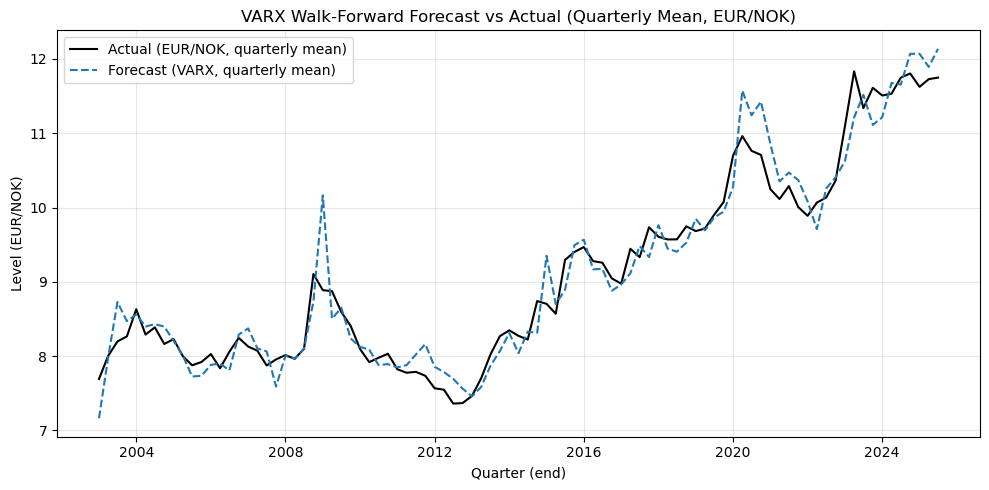


Average selected VARX lag (quarterly origins): 2.00


In [2]:
# Cell 3: Quarterly VARX – 1-quarter-ahead, evaluation, DM vs RW (EUR/NOK)

from statsmodels.tsa.api import VAR

max_p = 6
min_train_months = 36

quarter_ends = endog.index[endog.index.is_quarter_end]

rows_qx: List[Dict] = []
prev_p_quarterly: Optional[int] = None

for q_idx in range(1, len(quarter_ends)):
    origin = quarter_ends[q_idx - 1]  # last month of quarter t

    if origin < dates[min_train_months - 1]:
        continue

    # Target quarter: next 3 months
    q_start = origin + pd.offsets.MonthEnd(1)
    q_end = origin + pd.offsets.MonthEnd(3)

    if q_end > endog.index.max():
        break

    # Training window up to origin
    endog_train = endog.loc[:origin]
    exog_train = exog.loc[:origin]

    # Future horizon = all months in (origin, q_end]
    future_mask = (exog.index > origin) & (exog.index <= q_end)
    exog_future = exog.loc[future_mask]

    # Should be exactly 3 months
    H = len(exog_future)
    if H != 3:
        continue

    # Robust lag selection
    p_q = choose_var_lag(endog_train, max_p=max_p, prev_p=prev_p_quarterly)
    prev_p_quarterly = p_q

    model_q = VAR(endog_train, exog=exog_train)
    res_q = model_q.fit(p_q)

    y0_q = endog_train.values[-p_q:]
    y_f_q = res_q.forecast(y=y0_q, steps=H, exog_future=exog_future.values)
    path_df = pd.DataFrame(y_f_q, index=exog_future.index, columns=endog_vars)

    # EUR/NOK quarterly mean: forecast vs realised
    path_level = np.exp(path_df["s"])
    y_pred_q = float(path_level.mean())

    true_slice = df.loc[q_start:q_end, "EUR_NOK"]
    if len(true_slice) == 0:
        continue
    y_true_q = float(true_slice.mean())

    # Random walk quarterly benchmark: flat at last observed monthly EUR/NOK level at origin
    last_level = float(np.exp(endog_train.loc[origin, "s"]))
    y_rw_q = last_level

    rows_qx.append(
        {
            "quarter_end": q_end,
            "origin": origin,
            "y_true_q": y_true_q,
            "y_pred_q": y_pred_q,
            "y_rw_q": y_rw_q,
            "p_used_q": p_q,
        }
    )

df_eval_qx = pd.DataFrame(rows_qx).set_index("quarter_end").sort_index()

print("\n==============================")
print("Quarterly VARX – 1-quarter-ahead (EUR/NOK level)")
print("==============================")
print(f"Completed {len(df_eval_qx)} quarterly forecasts.")


# ----- Evaluation (Chronos-style) -----
def evaluate_quarterly_varx(df_eval_qx: pd.DataFrame) -> pd.DataFrame:
    """
    Level errors and directional accuracy for quarterly VARX (EUR/NOK).
    """
    df = df_eval_qx.copy()
    df["err"] = df["y_true_q"] - df["y_pred_q"]
    core = df.dropna(subset=["y_true_q", "y_pred_q"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(core["err"] ** 2))) if n_obs else np.nan
    mae = float(mean_absolute_error(core["y_true_q"], core["y_pred_q"])) if n_obs else np.nan

    # Directional accuracy vs previous quarter
    core["y_prev"] = core["y_true_q"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true_q"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred_q"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – VARX) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    eval_df = core[["y_true_q", "y_pred_q"]].rename(
        columns={"y_true_q": "y_true", "y_pred_q": "y_pred"}
    )
    # PeriodIndex for kvartaler, som i Chronos-oppsettet
    eval_df.index = eval_df.index.to_period("Q")
    return eval_df


def dm_against_random_walk_quarterly_varx(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """
    DM test vs random walk at quarterly horizon for VARX.
    Random walk: RW_q = y_{q-1}.
    """
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)

    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (VARX, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    if np.isfinite(dm_stat):
        print(f"DM-statistic: {dm_stat:.4f}")
    else:
        print("DM-statistic: nan")
    if np.isfinite(p_val):
        print(f"p-value     : {p_val:.4f}")
    else:
        print("p-value     : nan")


eval_qx = evaluate_quarterly_varx(df_eval_qx)
dm_against_random_walk_quarterly_varx(eval_qx, loss="mse", h=1)

# Plot quarterly actual vs VARX forecast
plt.figure(figsize=(10, 5))
x_q = eval_qx.index.to_timestamp()
plt.plot(
    x_q,
    eval_qx["y_true"],
    label="Actual (EUR/NOK, quarterly mean)",
    color="black",
)
plt.plot(
    x_q,
    eval_qx["y_pred"],
    linestyle="--",
    label="Forecast (VARX, quarterly mean)",
)
plt.title("VARX Walk-Forward Forecast vs Actual (Quarterly Mean, EUR/NOK)")
plt.xlabel("Quarter (end)")
plt.ylabel("Level (EUR/NOK)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"\nAverage selected VARX lag (quarterly origins): "
    f"{df_eval_qx['p_used_q'].mean():.2f}"
)
